# Grid Search

Recent progress on the parameter recovery exercise has pointed towards unstable regions and interactive effects between parameter combinations. Thus, a grid search may dispell any questions.

First, define the model.

In [1]:
import pyddm

def drift_function(avgWTP_left, avgWTP_right, fixation, d, theta, t):
    fixation_index = min(int(t/0.001), len(fixation)-1)
    current_fixation = fixation[fixation_index]
    if current_fixation == 0: # saccade
        return 0
    elif current_fixation == 1: # left
        return d * (avgWTP_left -  avgWTP_right * theta)
    else: # right
        return d * (avgWTP_left * theta -  avgWTP_right)

model = pyddm.gddm(drift=drift_function, noise=0.57, bound=1, nondecision=0,
               parameters={"d": (1, 3), "theta": (0, 1)},
               conditions=["avgWTP_left", "avgWTP_right", "fixation"],
               choice_names=("left", "right"),
               T_dur = 5,
               dx = 0.001,
               dt = 0.001
)

Then define the sample.

In [2]:
import pandas as pd
import ast

simulated_df = pd.read_csv('simulated_trials.csv')
simulated_df['fixation'] = simulated_df['fixation'].apply(ast.literal_eval)

sample = pyddm.Sample.from_pandas_dataframe(
    simulated_df,
    choice_column_name="choice",
    rt_column_name="RT",
    choice_names=("left", "right")
)

Then define the grid.

In [3]:
import itertools
import numpy as np

d_vals = np.linspace(1, 3, 5)
theta_vals = np.linspace(0.28, 0.48, 5)

grid = list(itertools.product(d_vals, theta_vals))
grid

[(np.float64(1.0), np.float64(0.28)),
 (np.float64(1.0), np.float64(0.33)),
 (np.float64(1.0), np.float64(0.38)),
 (np.float64(1.0), np.float64(0.43)),
 (np.float64(1.0), np.float64(0.48)),
 (np.float64(1.5), np.float64(0.28)),
 (np.float64(1.5), np.float64(0.33)),
 (np.float64(1.5), np.float64(0.38)),
 (np.float64(1.5), np.float64(0.43)),
 (np.float64(1.5), np.float64(0.48)),
 (np.float64(2.0), np.float64(0.28)),
 (np.float64(2.0), np.float64(0.33)),
 (np.float64(2.0), np.float64(0.38)),
 (np.float64(2.0), np.float64(0.43)),
 (np.float64(2.0), np.float64(0.48)),
 (np.float64(2.5), np.float64(0.28)),
 (np.float64(2.5), np.float64(0.33)),
 (np.float64(2.5), np.float64(0.38)),
 (np.float64(2.5), np.float64(0.43)),
 (np.float64(2.5), np.float64(0.48)),
 (np.float64(3.0), np.float64(0.28)),
 (np.float64(3.0), np.float64(0.33)),
 (np.float64(3.0), np.float64(0.38)),
 (np.float64(3.0), np.float64(0.43)),
 (np.float64(3.0), np.float64(0.48))]

Now run the grid search on a new model.

In [4]:
from pyddm.models.loss import LossLikelihood

results = []

for d_vals, theta_vals in grid:
    m = pyddm.gddm(drift=drift_function, noise=0.57, bound=1, nondecision=0,
               parameters={"d": d_vals, "theta": theta_vals},
               conditions=["avgWTP_left", "avgWTP_right", "fixation"],
               choice_names=("left", "right"),
               T_dur = 5,
               dx = 0.001,
               dt = 0.001
        )

    lossfunc = LossLikelihood(sample=sample, model=m, dt=m.dt, T_dur=m.T_dur)
    print(f'Running params [{d_vals}, {theta_vals}] in loss().')
    nll = lossfunc.loss(m)
    print(f'Ran params [{d_vals}, {theta_vals}] in loss() with a nll of {nll}.')
    results.append({
        "drift": d_vals,
        "theta": theta_vals,
        "nll": nll
    })

Running params [1.0, 0.28] in loss().
Ran params [1.0, 0.28] in loss() with a nll of 2665.703864938834.
Running params [1.0, 0.33] in loss().
Ran params [1.0, 0.33] in loss() with a nll of 2653.7539828869667.
Running params [1.0, 0.38] in loss().
Ran params [1.0, 0.38] in loss() with a nll of 2640.1437112734543.
Running params [1.0, 0.43] in loss().
Ran params [1.0, 0.43] in loss() with a nll of 2624.267556669372.
Running params [1.0, 0.48] in loss().
Ran params [1.0, 0.48] in loss() with a nll of 2605.1270649824028.
Running params [1.5, 0.28] in loss().
Ran params [1.5, 0.28] in loss() with a nll of 2824.5226116751573.
Running params [1.5, 0.33] in loss().
Ran params [1.5, 0.33] in loss() with a nll of 2827.2917975736423.
Running params [1.5, 0.38] in loss().
Ran params [1.5, 0.38] in loss() with a nll of 2828.4078906396758.
Running params [1.5, 0.43] in loss().
Ran params [1.5, 0.43] in loss() with a nll of 2825.497740740235.
Running params [1.5, 0.48] in loss().
Ran params [1.5, 0.4

Finally, plot the results.

In [5]:
# Convert to pandas DataFrame for convenience
results_df = pd.DataFrame(results)

heatmap_data = results_df.pivot(
    index="theta",
    columns="drift",
    values="nll"
)

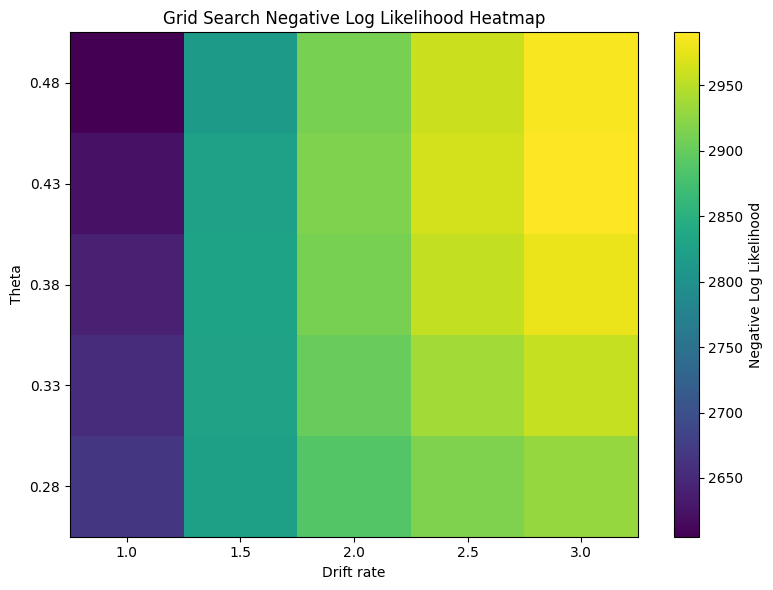

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
im = plt.imshow(
    heatmap_data.values,
    origin="lower",
    aspect="auto",
    cmap="viridis"
)

plt.colorbar(im, label="Negative Log Likelihood")

plt.xticks(
    range(len(heatmap_data.columns)),
    labels=np.round(heatmap_data.columns, 3)
)
plt.yticks(
    range(len(heatmap_data.index)),
    labels=np.round(heatmap_data.index, 3)
)

plt.xlabel("Drift rate")
plt.ylabel("Theta")
plt.title("Grid Search Negative Log Likelihood Heatmap")
plt.tight_layout()
plt.show()
